# SHAP MNIST

This notebook shows how SHAP works using the MNIST dataset and a PyTorch model.

The code is based on the [SHAP MNIST example](https://shap.readthedocs.io/en/stable/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html). The notebook with the example code is available [on GitHub](https://github.com/slundberg/shap/blob/master/notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.ipynb).

## Neural network training

In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

In [2]:
batch_size = 128
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [3]:
num_epochs = 1
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317497
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.224162
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.586792
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.008361
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.806852

Test set: Average loss: 0.0042, Accuracy: 9050/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.683545
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.704268
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.547789
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.473305
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.376226

Test set: Average loss: 0.0023, Accuracy: 9446/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.548097
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.332602
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.601303
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.343058
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.579931

Test set: Average loss: 0.0016, Accuracy: 9583/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.215523
Train Epoch: 4 [12800/60000 (21%)]	Lo

## SHAP feature attributions

Extract a batch of images and their labels from the test set.

In [45]:
batch = next(iter(test_loader))
images, target = batch

datad, targetd = images.to(device), target.to(device)

Get their predicted probabilities and predicted label (with argmax).

In [46]:
output = model(datad)
pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

# Convert to numpy only once to save time
target_np = target.numpy()
pred_np = pred.numpy()

"Select a set of background examples to take an expectation over" (from the [SHAP README](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models))

In [47]:
BACKGROUND_SIZE = 100
background = images[:BACKGROUND_SIZE]
e = shap.DeepExplainer(model, background)

What is left from the test batch will be used to show feature attribution.

In [48]:
test_images = images[BACKGROUND_SIZE:]

Show the SHAP feature atribution for each image. We could have passed the entire array of images to `image_plot`, but we would lose resolution with that (see the test code). Processing each image separately results in a larger graph, making the attributions easier to see.

How to read the attributions:

- Red pixels increases the probability of a class being predicted
- Blue pixels decrease the probability of a class being predicted

See an explanation of "red vs. blue" [in this page of the SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Image%20Multi%20Class.html#Visualizing-SHAP-values-output).

**NOTE** that a disadvantage of ploting each image separately is that the SHAP value scale changes from one image to the next. We cannot compare the colors from one image to others in this format. To compare colors acorss images we need to plot all of them with one call to `image_plot`, as it's done in the original sample code. See the test code after this section if you want to see all images in one plot.

Predicted 0
Actual 0
[9.8158652e-01 5.5365882e-07 5.1352516e-05 2.3599134e-05 2.8148506e-06
 1.7122069e-02 2.3013788e-04 3.8445508e-04 4.5168566e-04 1.4660868e-04]


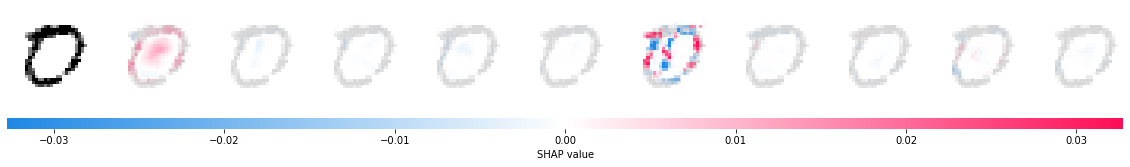

Predicted 8
Actual 8
[4.2006434e-03 4.3227649e-03 2.3120238e-02 7.3972899e-03 3.7686460e-04
 1.8732550e-02 2.2249989e-02 1.0764959e-04 9.1764104e-01 1.8511886e-03]


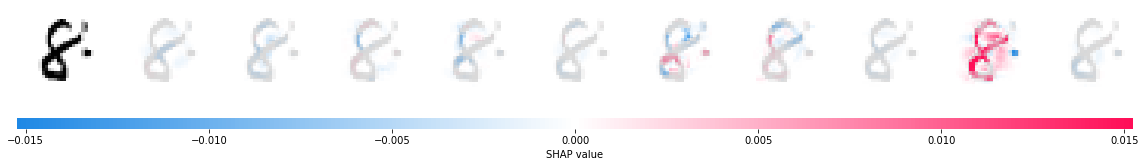

Predicted 1
Actual 1
[2.4943201e-05 9.9550700e-01 4.4523415e-04 1.1831558e-04 1.6134050e-03
 2.3068284e-04 1.0642291e-03 6.9442925e-05 7.2538789e-04 2.0130168e-04]


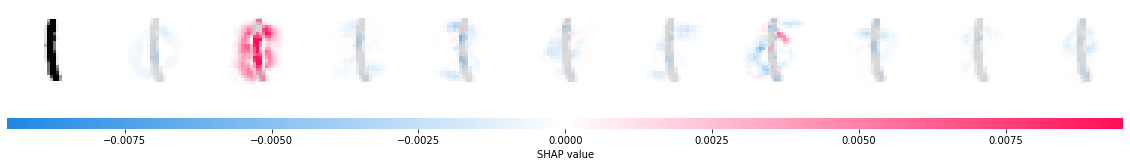

Predicted 0
Actual 0
[9.9909520e-01 5.9832871e-07 3.9857347e-04 5.2480705e-06 2.2417296e-06
 1.2964329e-04 1.7370058e-04 3.9302948e-05 9.7446675e-05 5.8039703e-05]


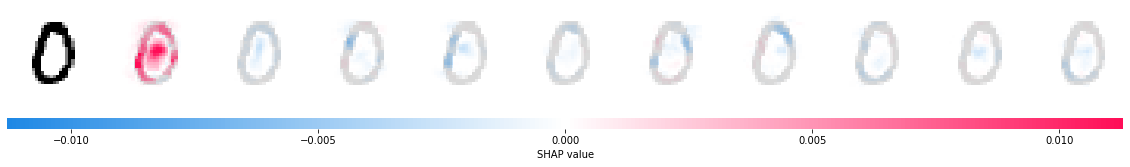

Predicted 1
Actual 1
[0.00218482 0.9207771  0.01073546 0.0131191  0.00925668 0.00577868
 0.00456088 0.01178375 0.01108588 0.01071757]


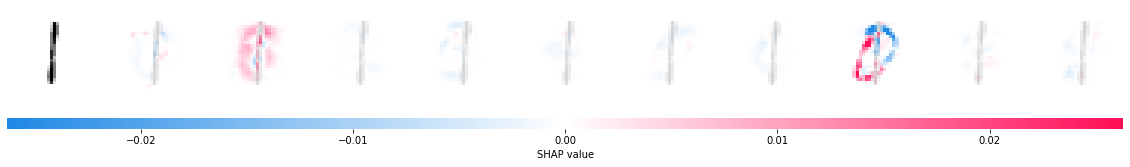

Predicted 4
Actual 4
[9.7485363e-06 4.2571637e-04 1.4501389e-03 2.6776461e-06 9.9720830e-01
 2.4448723e-06 8.1233430e-04 2.6546317e-05 7.9803776e-06 5.4161144e-05]


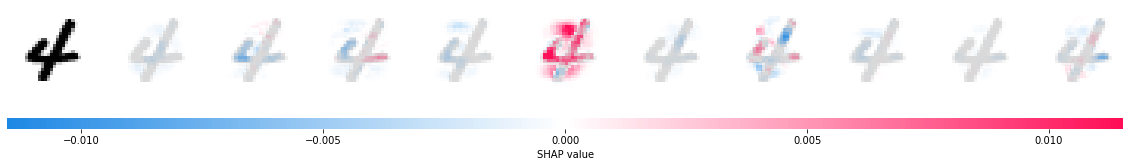

Predicted 4
Actual 4
[6.6442617e-08 5.6672023e-05 6.9110547e-06 2.6262180e-07 9.9962318e-01
 1.9967472e-06 7.3054061e-06 2.9108323e-06 1.2774154e-05 2.8799401e-04]


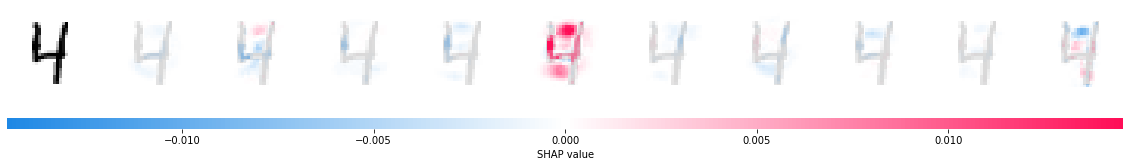

Predicted 9
Actual 9
[3.3447257e-05 5.1522919e-04 6.7359151e-04 3.5492731e-03 5.0404817e-02
 2.1688938e-03 1.4258490e-05 1.4508804e-02 2.3971604e-02 9.0416014e-01]


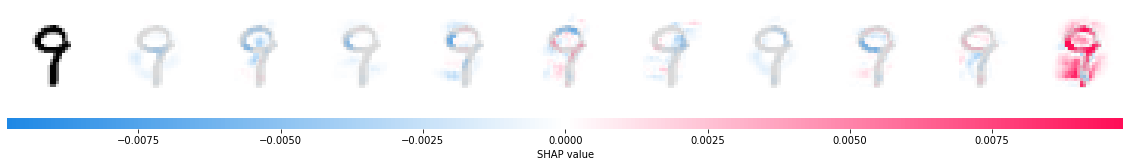

Predicted 7
Actual 7
[1.0548968e-05 6.1889223e-06 3.0255411e-05 3.1703985e-05 5.3640688e-05
 2.3522727e-05 5.6472329e-09 9.9589205e-01 1.5532753e-05 3.9365008e-03]


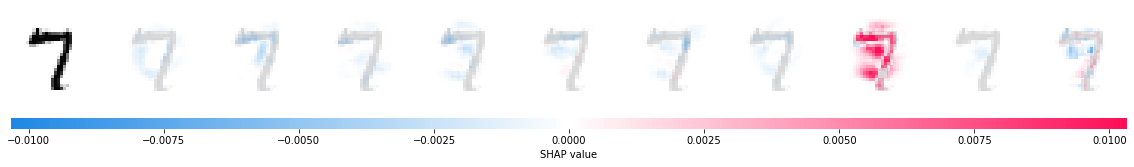

Predicted 4
Actual 4
[4.5803745e-08 3.3880591e-05 1.8552182e-05 2.5896722e-06 9.9918312e-01
 3.1179284e-06 2.4738154e-06 1.1222835e-05 2.4108045e-05 7.2086224e-04]


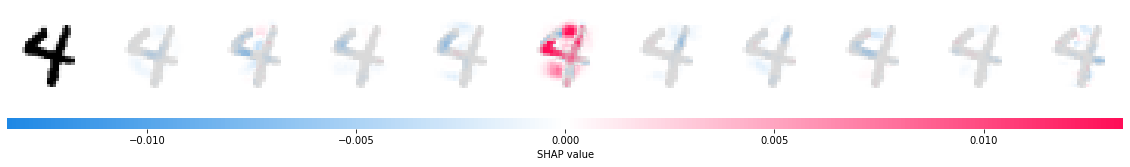

Predicted 5
Actual 5
[0.3703924  0.0016517  0.00430683 0.15663543 0.00317482 0.38935998
 0.01844998 0.00403527 0.02849031 0.02350331]


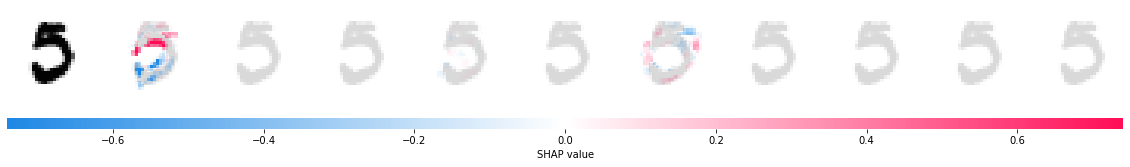

Predicted 8
Actual 8
[1.0767179e-03 3.0449884e-02 4.6521854e-02 4.7165886e-02 1.7208398e-03
 3.5979887e-03 2.4737648e-04 1.2138969e-02 8.3309704e-01 2.3983378e-02]


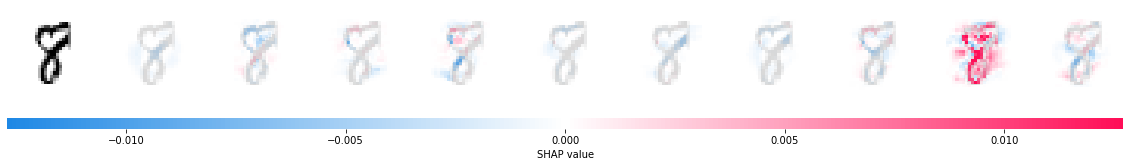

Predicted 6
Actual 6
[6.6781027e-04 2.6291012e-04 1.5059220e-04 7.8362370e-07 1.3893620e-03
 4.4039616e-04 9.9672359e-01 2.2986198e-07 3.5175410e-04 1.2540491e-05]


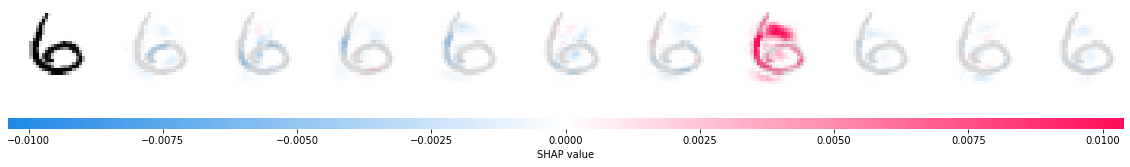

Predicted 4
Actual 4
[1.3691900e-07 2.2317952e-04 4.8079160e-05 2.2671537e-07 9.9962008e-01
 7.0919975e-07 6.7061024e-05 1.5007804e-06 1.0197659e-05 2.8720360e-05]


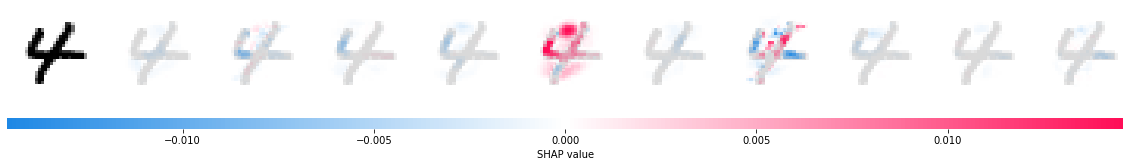

Predicted 9
Actual 9
[2.3438071e-05 3.5961912e-05 4.7633637e-04 2.2795729e-03 3.3520520e-02
 5.2084756e-04 1.2955693e-06 3.1936862e-02 1.8991323e-03 9.2930585e-01]


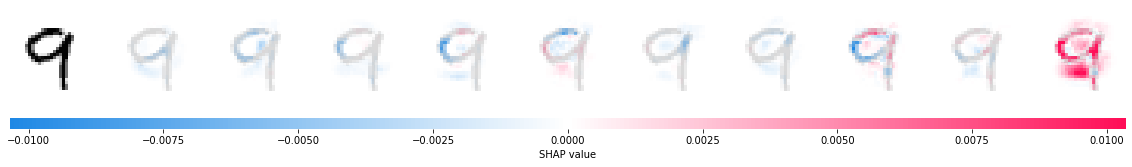

Predicted 6
Actual 6
[8.8552730e-03 1.1234755e-03 1.4499997e-03 4.5290049e-05 8.5493475e-03
 2.5205209e-03 9.7535872e-01 1.7548160e-05 1.7313964e-03 3.4841752e-04]


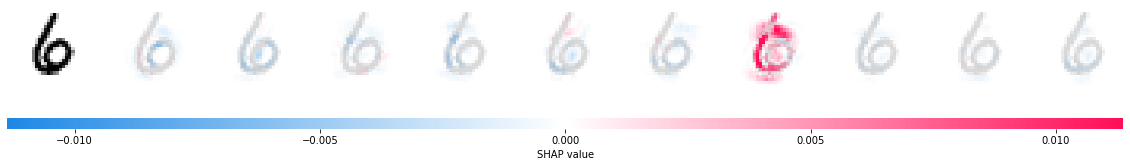

Predicted 8
Actual 8
[2.2153385e-04 1.4807649e-04 2.5931059e-03 5.3348839e-03 7.7727433e-05
 1.0386341e-02 1.4495192e-04 9.9743869e-05 9.7869337e-01 2.3002464e-03]


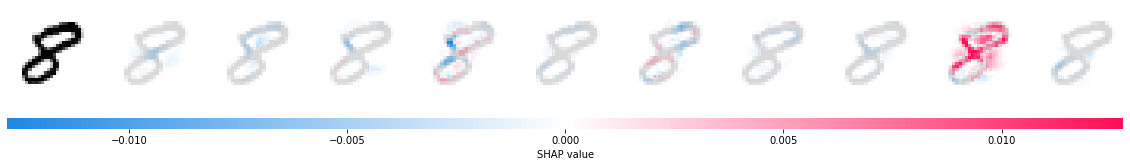

Predicted 7
Actual 7
[4.4378985e-06 2.0251508e-05 1.6386734e-04 1.8386748e-04 1.5973441e-05
 4.2876713e-06 7.8782275e-10 9.9649870e-01 2.4037497e-05 3.0844999e-03]


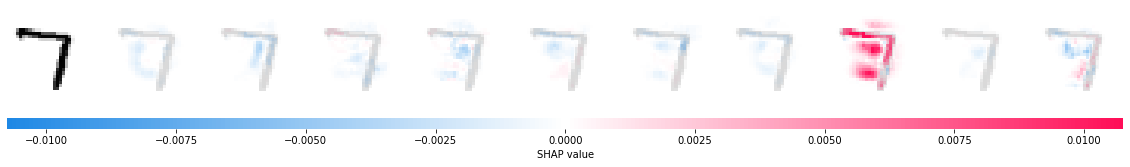

Predicted 2
Actual 7
[3.1003630e-04 5.2085342e-03 5.6396830e-01 2.8231531e-02 4.8043821e-05
 4.4330336e-05 5.2676442e-06 3.9888573e-01 2.4108640e-03 8.8739721e-04]


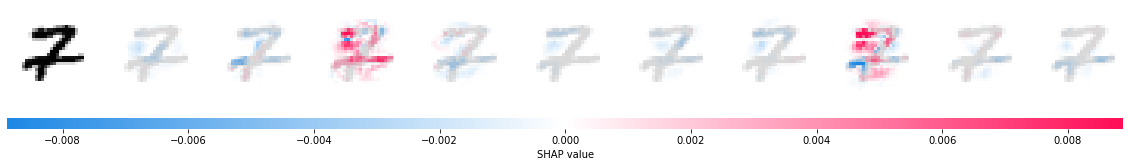

Predicted 8
Actual 8
[1.6898614e-04 5.7594076e-04 1.9173452e-03 2.1151477e-03 3.6790053e-04
 1.6949616e-02 1.9529047e-03 3.8802515e-05 9.7319263e-01 2.7208538e-03]


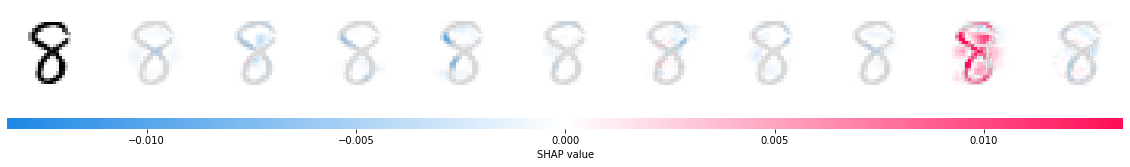

Predicted 9
Actual 9
[7.5360702e-05 1.8141459e-04 2.3255673e-04 2.9245904e-03 1.3491291e-01
 5.6820563e-03 4.5908091e-05 7.0911599e-03 6.0870745e-03 8.4276694e-01]


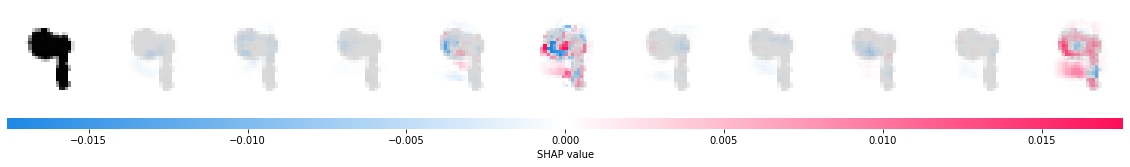

Predicted 7
Actual 7
[1.6087755e-06 1.0185418e-05 3.8300277e-05 4.2106327e-05 8.4794829e-06
 2.7082804e-06 3.0911512e-10 9.9795842e-01 1.1546842e-05 1.9266122e-03]


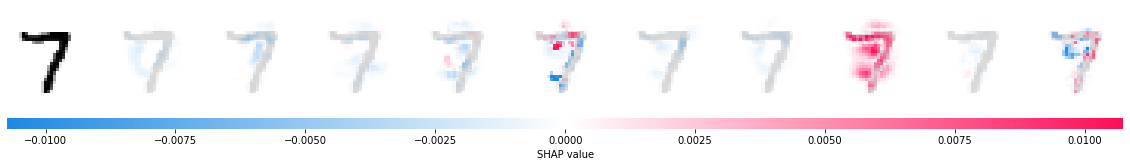

Predicted 7
Actual 7
[6.0303550e-04 3.9285762e-05 2.0929369e-04 2.2231972e-04 2.6276945e-03
 3.3617750e-04 1.3087550e-06 9.0474057e-01 1.0851099e-04 9.1111764e-02]


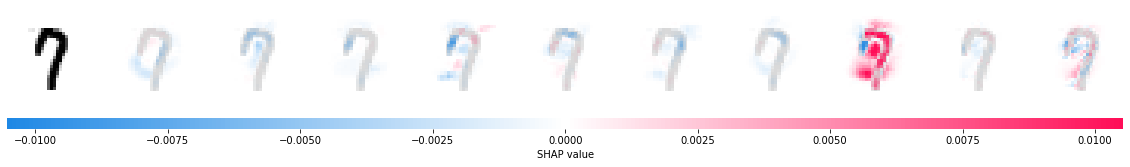

Predicted 2
Actual 2
[2.5748415e-04 2.3348390e-03 9.9096370e-01 3.6589159e-03 9.1104284e-06
 5.2502869e-06 1.4652568e-05 2.3184218e-03 4.0091295e-04 3.6727633e-05]


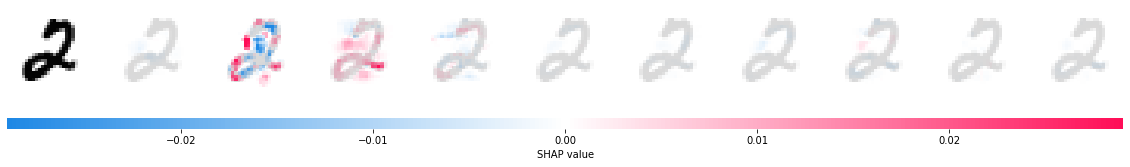

Predicted 6
Actual 6
[3.4181762e-02 3.5162515e-03 1.7396867e-02 2.7430977e-04 1.1994203e-01
 3.4408795e-03 8.1571895e-01 4.5699615e-04 2.0163606e-03 3.0555420e-03]


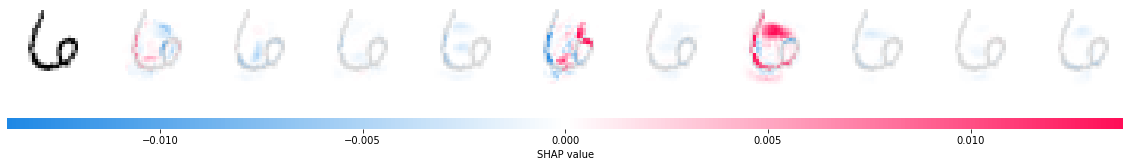

Predicted 9
Actual 9
[2.6976934e-04 2.8389042e-05 1.9755948e-03 7.5372234e-03 5.1228613e-02
 1.3348567e-02 4.3990069e-05 3.7038304e-02 6.1108773e-03 8.8241857e-01]


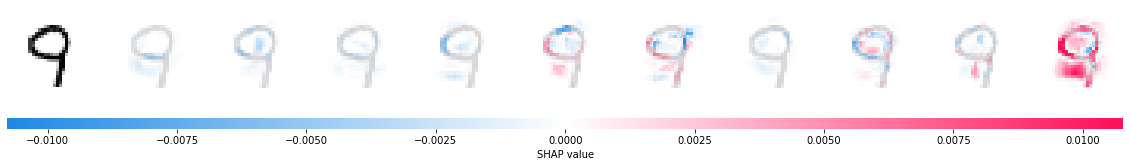

Predicted 4
Actual 4
[5.05029220e-07 1.11559966e-04 3.15184298e-04 1.78038012e-04
 9.93741691e-01 2.78283787e-05 3.47162586e-06 9.41641920e-05
 1.54285372e-04 5.37321530e-03]


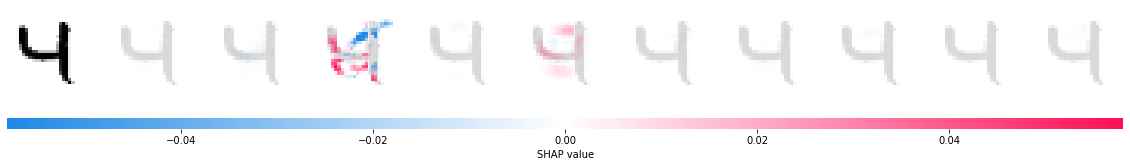

Predicted 9
Actual 9
[0.00146857 0.00137406 0.00538446 0.01195522 0.3487745  0.01579229
 0.00059825 0.06808779 0.01087519 0.5356896 ]


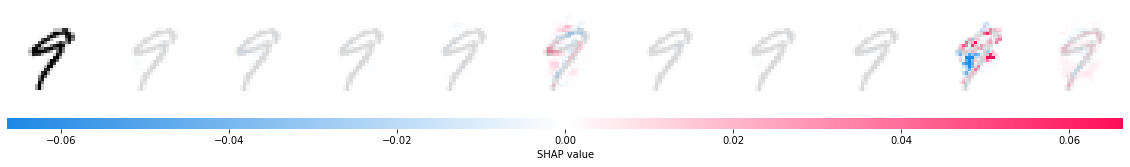

In [50]:
for i in range(0,len(test_images)):
    test_index = BACKGROUND_SIZE + i
    print('Predicted', pred_np[test_index][0])
    print('Actual', target_np[test_index])
    print(output[test_index].detach().numpy())

    ti = test_images[[i]]
    sv = e.shap_values(ti)
    sn = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv]
    tn = np.swapaxes(np.swapaxes(ti.numpy(), 1, -1), 1, 2)
    shap.image_plot(sn, -tn)

# Test code

This section has the original code from the [SHAP MNIST example](https://shap.readthedocs.io/en/stable/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html). Use this section to check that the code in the previous section is showing the correct SHAP images.

To make the code comparable, we reuse the same images loaded in the previous section, but we redo all calculations following the sample code, to ensure that we didn't introduce a bug in the previous section.

The sequence of digits in this section and their feature attributions must match the ones in the previous sections.

In [51]:
# Turn the test code on when needed to not pollute the notebook
TEST_CODE = True

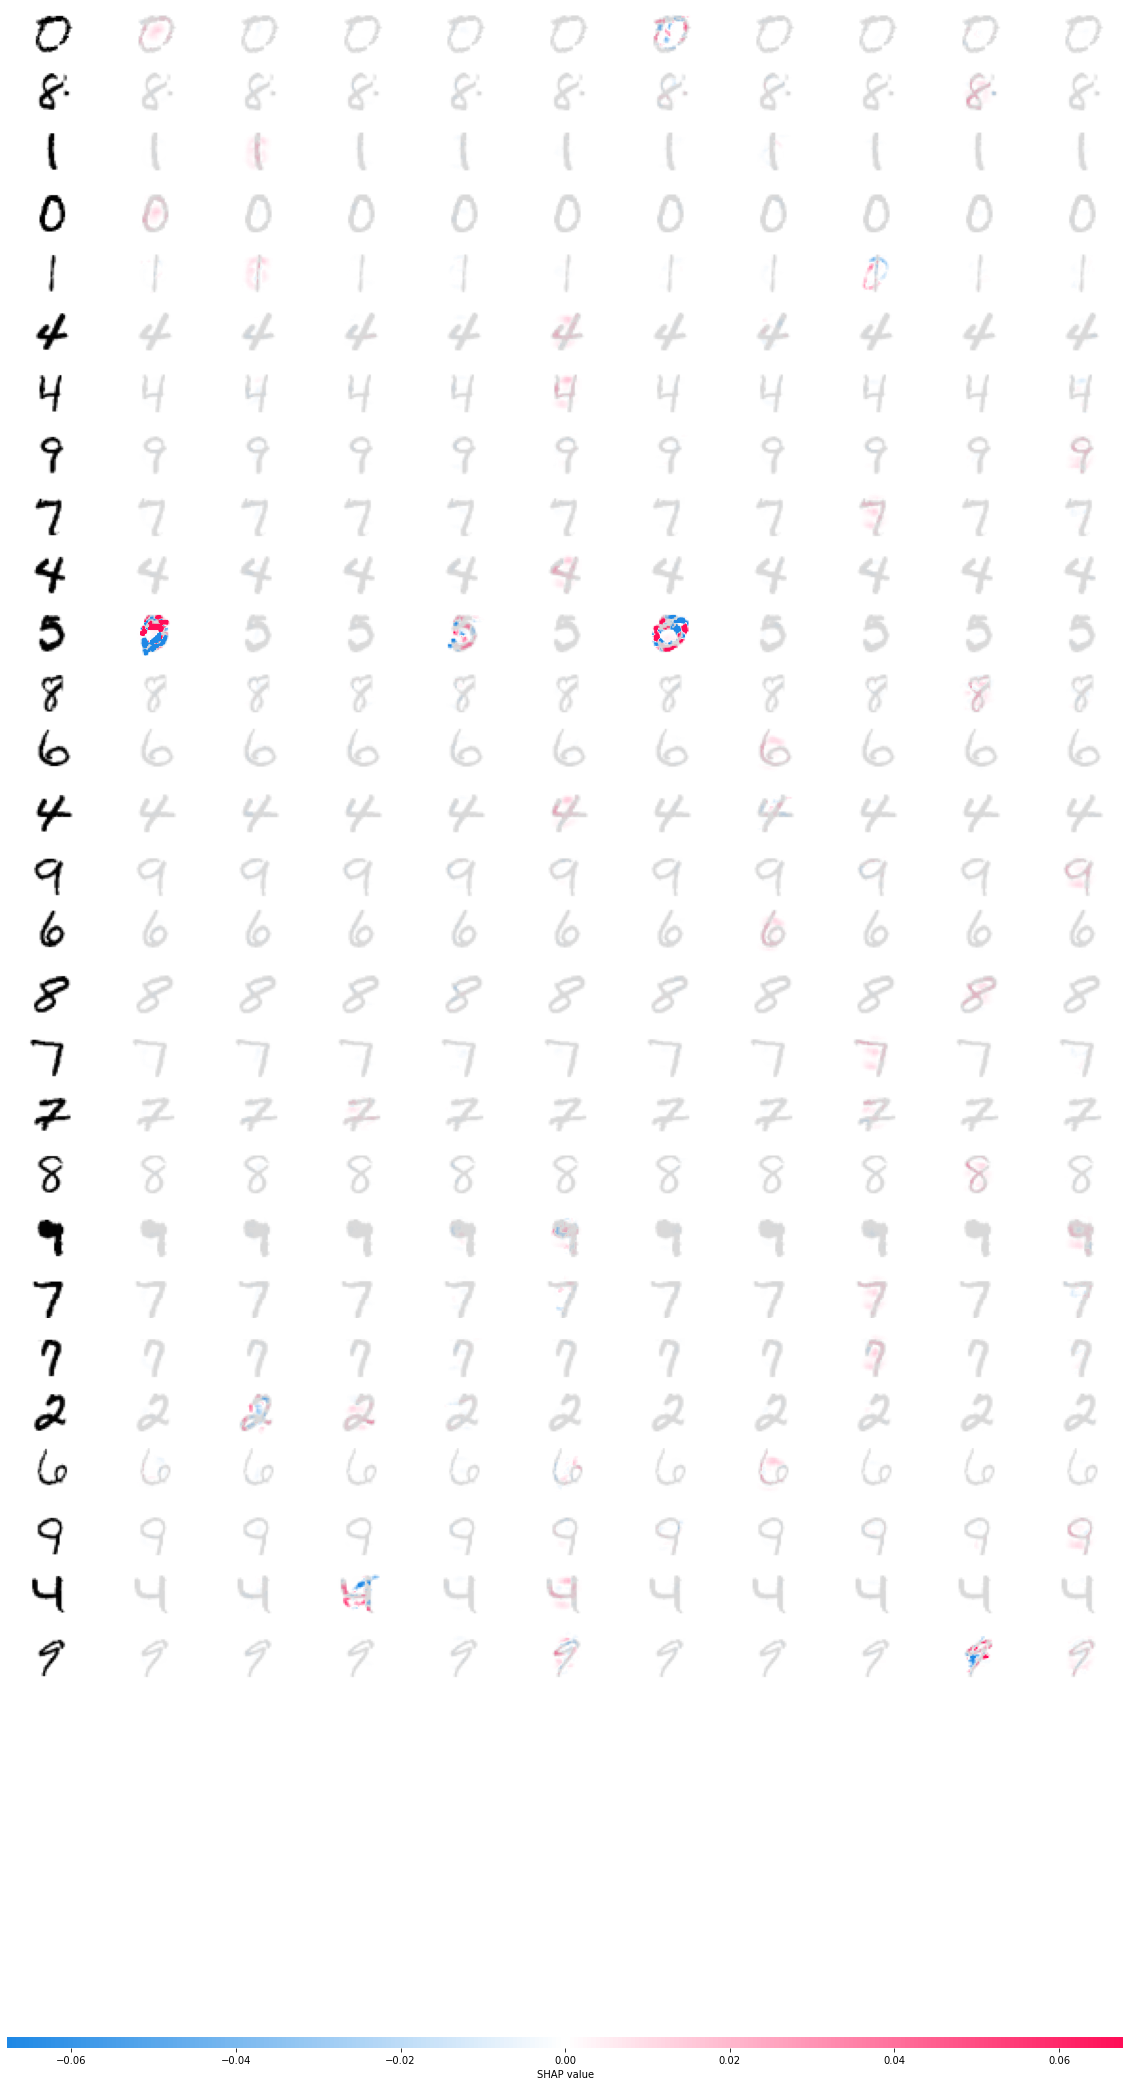

In [52]:
if TEST_CODE:
    e = shap.DeepExplainer(model, background)
    shap_values = e.shap_values(test_images)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
    
    shap.image_plot(shap_numpy, -test_numpy)